In [1]:
config_name = "Finetune"

In [2]:
""" setup """

import torch
import lightning
import numpy as np
import pandas as pd

import os
import tqdm
import warnings
import dataclasses
import matplotlib.pyplot as plt

import src

torch.set_float32_matmul_precision("medium")
lightning.seed_everything(42, workers=True, verbose=False)
# disable MPS UserWarning: The operator 'aten::col2im' is not currently 
# supported on the MPS backend
warnings.filterwarnings("ignore", message=".*MPS.*fallback.*")

# device
if torch.cuda.is_available(): device = "cuda"
elif torch.backends.mps.is_available(): device = "mps"
else: device = "cpu"

# config
config: src.config.Config = getattr(src.config, config_name)()

# data
data = src.data.Module(**vars(config.data))
data.setup()

In [18]:
subject = "S001"
config.runner.weight_min = 0.5
config.runner.weight_max = 0.5

In [19]:
""" load pretrained model and predict backbone outputs """

# load pretrained model
model = src.model.SCOST(**vars(config.model))
if config.trainer.ckpt_load_path is None: raise ValueError
model = src.util.ckptLoader_(model, config.trainer.ckpt_load_path).to(device)
model.freeze()

# predict backbone outputs
model.eval()
x, y = [], []   # (N, L, D), (N, T)
for batch in data.train_dataloader(subject=subject):
    batch = [b.to(device) for b in batch]
    with torch.no_grad(): 
        x.append(model.forward(batch[0], batch[1], pool_dim=1))
    y.append(batch[2])
x_train, y_train = torch.cat(x, dim=0), torch.cat(y, dim=0) 
x, y = [], []   # (N, L, D), (N, T)
for batch in data.val_dataloader(subject=subject):
    batch = [b.to(device) for b in batch]
    with torch.no_grad(): 
        x.append(model.forward(batch[0], batch[1], pool_dim=1))
    y.append(batch[2])
x_valid, y_valid = torch.cat(x, dim=0), torch.cat(y, dim=0)

100%|██████████| 1000/1000 [00:08<00:00, 118.78it/s]


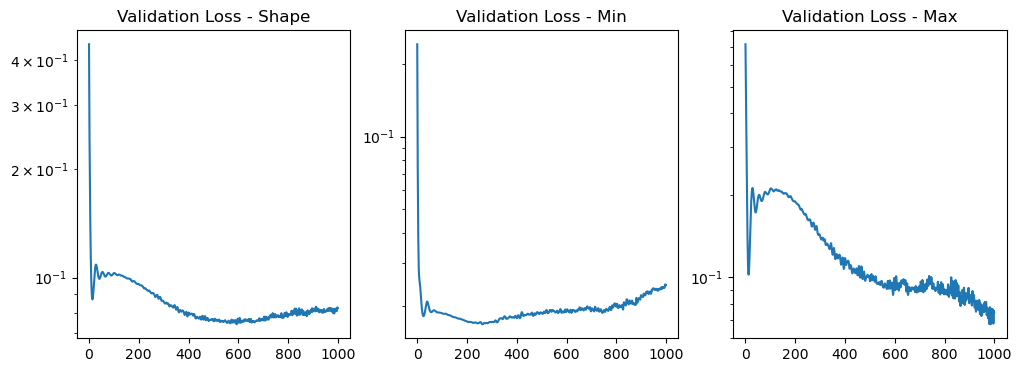

In [20]:
""" train subject-specific adapter """

def lossShape(x, y):
    return torch.nn.functional.smooth_l1_loss(  # (B,)
        input=torch.stack([
            torch.roll(x, shifts=s, dims=-1) 
            for s in range(-config.runner.K, config.runner.K+1)
        ], dim=1)[:, :, config.runner.K:-config.runner.K],
        target=y.unsqueeze(1).expand(
            (-1, 2*config.runner.K+1, -1)
        )[:, :, config.runner.K:-config.runner.K],
        reduction='none'
    ).mean(dim=-1).min(dim=-1).values.mean()
def lossMin(x, y):
    return torch.nn.functional.smooth_l1_loss(  # (B,)
        x.min(dim=-1).values, y.min(dim=-1).values
    )
def lossMax(x, y):
    return torch.nn.functional.smooth_l1_loss(  # (B,)
        x.max(dim=-1).values, y.max(dim=-1).values
    )

valid_loss_shape_list, valid_loss_min_list, valid_loss_max_list = [], [], []

optimizer = torch.optim.AdamW(model.parameters(), lr=config.runner.lr)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, config.runner.step_size, gamma=config.runner.gamma
)
for epoch in tqdm.tqdm(range(config.trainer.max_epochs)):
    # train
    model.train()
    x = model.forwardAdapter(x_train)
    train_loss_shape = lossShape(x, y_train)
    train_loss_min   = lossMin(x, y_train)
    train_loss_max   = lossMax(x, y_train)
    train_loss = (
        config.runner.weight_shape * train_loss_shape +
        config.runner.weight_min * train_loss_min +
        config.runner.weight_max * train_loss_max
    )
    # backprop
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    # scheduler.step()
    # validate
    model.eval()
    with torch.no_grad():
        x = model.forwardAdapter(x_valid)
    valid_loss_shape = lossShape(x, y_valid)
    valid_loss_min   = lossMin(x, y_valid)
    valid_loss_max   = lossMax(x, y_valid)
    valid_loss = (
        config.runner.weight_shape * valid_loss_shape +
        config.runner.weight_min * valid_loss_min +
        config.runner.weight_max * valid_loss_max
    )
    # log
    valid_loss_shape_list.append(valid_loss_shape.item())
    valid_loss_min_list.append(valid_loss_min.item())
    valid_loss_max_list.append(valid_loss_max.item())

# visualize validation losses, log scale
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(valid_loss_shape_list)
plt.title("Validation Loss - Shape")
plt.yscale("log")
plt.subplot(1,3,2)
plt.plot(valid_loss_min_list)
plt.title("Validation Loss - Min")
plt.yscale("log")
plt.subplot(1,3,3)
plt.plot(valid_loss_max_list)
plt.title("Validation Loss - Max")
plt.yscale("log")
plt.show()

In [21]:
""" prediction on all data """

# predict
result_b = []
model.eval()
for batch in tqdm.tqdm(data.test_dataloader()):
    # batch to device
    x, channel_idx, y = batch
    x, channel_idx, y = x.to(device), channel_idx.to(device), y.to(device)
    # forward
    with torch.no_grad(): x_pred = model.forwardRegression(
        x, channel_idx, adapter=True
    )
    # store result
    result_b.append(torch.cat([
        x.detach().cpu(),                       # (B, 4, T)
        y.detach().cpu().unsqueeze(1),          # (B, 1, T)
        x_pred.detach().cpu().unsqueeze(1),     # (B, 1, T)
    ], dim=1))
result = torch.cat(result_b, dim=0)            # (N, 5, T)
# map bp in 3nd and 4th channel to waveform before normalization
# and store new waveform in 5th and 6th channel
result = torch.cat([
    result, 
    data.denormalize(result[:, 3, :]).unsqueeze(1),
    data.denormalize(result[:, 4, :]).unsqueeze(1),
], dim=1).detach().cpu()
# store key features in profile
profile = data.profile.copy()
profile["split"] = profile["split"].map({0: "train", 1: "test", 2: "test"})
profile["system"] = profile["system"].map({False: "old", True: "new"})
profile["TrueMinBP"] = result[:, 5].min(dim=1).values.numpy()
profile["TrueMaxBP"] = result[:, 5].max(dim=1).values.numpy()
profile["PredMinBP"] = result[:, 6].min(dim=1).values.numpy()
profile["PredMaxBP"] = result[:, 6].max(dim=1).values.numpy()
profile["(P-T)MinBP"] = profile["PredMinBP"] - profile["TrueMinBP"]
profile["(P-T)MaxBP"] = profile["PredMaxBP"] - profile["TrueMaxBP"]


print("train: {}\tMAE of (min, max) = ({:5.2f}, {:5.2f})".format(
    subject,
    np.nanmean(np.abs(
        profile[
            (profile["subject"] == subject) & (profile["condition"] == 1)
        ]["(P-T)MinBP"]
    )),
    np.nanmean(np.abs(
        profile[
            (profile["subject"] == subject) & (profile["condition"] == 1)
        ]["(P-T)MaxBP"]
    )),
))
print("valid: {}\tMAE of (min, max) = ({:5.2f}, {:5.2f})".format(
    subject,
    np.nanmean(np.abs(
        profile[
            (profile["subject"] == subject) & (profile["condition"] != 1)
        ]["(P-T)MinBP"]
    )),
    np.nanmean(np.abs(
        profile[
            (profile["subject"] == subject) & (profile["condition"] != 1)
        ]["(P-T)MaxBP"]
    )),
))

100%|██████████| 122/122 [00:04<00:00, 28.33it/s]


train: S001	MAE of (min, max) = ( 0.57,  1.13)
valid: S001	MAE of (min, max) = ( 3.54,  6.09)


In [22]:
visualization = src.util.Visualization(result, profile.copy())